# Intro Task, Object Localization

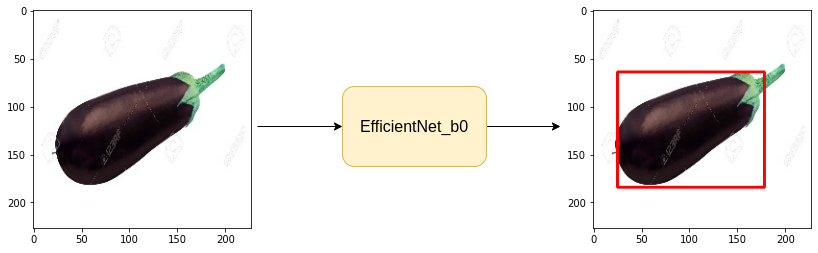

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-vyuy1ge7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-vyuy1ge7
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=762b4227bdc83e3297041fc0f2ec3daa558e84a5a35504696ce2f684c39938b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xx57tffn/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 4.14 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE='/content/object-localization-dataset/train.csv'
DATA_DIR='/content/object-localization-dataset/'
DEVICE='cuda'
BATCH_SIZE=16
IMG_SIZE=140
LR=0.001
EPOCHS=40
MODEL_NAME='efficientnet_b0'
NUM_COR=4

In [ ]:
df=pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

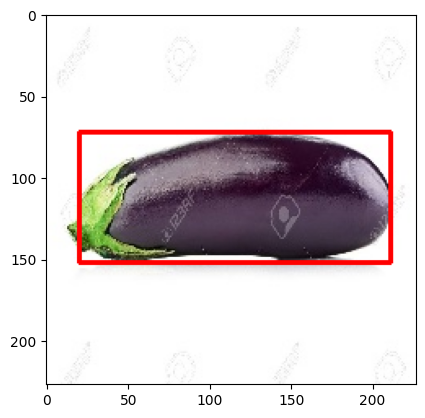

In [ ]:
from cv2.gapi import BGR2RGB
row=df.iloc[123]
img=cv2.imread(DATA_DIR+row.img_path)
#cv2 reads iamges in BGR format
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1=(row.xmin,row.ymin)
pt2=(row.xmax,row.ymax)
bnd_box_img=cv2.rectangle(img, pt1,pt2,(255,0,0,),2)

plt.imshow(bnd_box_img)

In [ ]:
train_df,val_df=train_test_split(df,test_size=0.20,random_state=42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs=A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))
val_augs=A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class OLD(torch.utils.data.Dataset):
  def __init__(self,df,augmentations=None):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    xmin=row.xmin
    ymin=row.ymin
    xmax=row.xmax
    ymax=row.ymax

    bbox=[[xmin,ymin,xmax,ymax]]
    img_path=DATA_DIR+row.img_path
    img=cv2.imread(img_path)#numpy imqages->(height,width,channel)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data=self.augmentations(image=img,bboxes=bbox,class_labels=[None])
      img=data['image']
      bbox=data['bboxes'][0]

    img=torch.from_numpy(img).permute(2,0,1)/255.0 #(channel,height,width)->scale
    bbox=torch.Tensor(bbox)

    return img,bbox


In [ ]:
trainset=OLD(train_df,train_augs)
valset=OLD(val_df,val_augs)

In [ ]:
print(trainset.__len__())
print(valset.__len__())

148
38


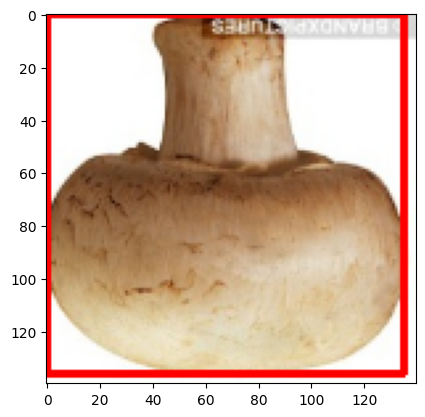

In [ ]:
img, bbox = trainset[15]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valloader=torch.utils.data.DataLoader(valset,batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in valloader : {}".format(len(valloader)))

Total no. batches in trainloader : 10
Total no. batches in valloader : 3


In [ ]:
for images,bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm#pytorch image library

In [ ]:
class OLModel(nn.Module):
  def __init__(self):
    super(OLModel, self).__init__()
    self.backbone=timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)

  def forward(self, images, gt_bboxes=None):
    bboxes=self.backbone(images)

    if gt_bboxes!=None:
      loss=nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes,loss

    return bboxes

In [ ]:
model=OLModel()
model.to(DEVICE)

OLModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1

In [ ]:
rnd_img=torch.rand(1,3,140,140).to(DEVICE)
model(rnd_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model,dataloader,optimizer):
  total_loss=0.0
  model.train()#Dropout ON

  for data in tqdm(dataloader):
    images,gt_bboxes=data
    images,gt_bboxes=images.to(DEVICE),gt_bboxes.to(DEVICE)

    bboxes,loss=model(images, gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader)

In [ ]:
def val_fn(model,dataloader):
  total_loss=0.0
  model.eval()#Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,gt_bboxes=data
      images,gt_bboxes=images.to(DEVICE),gt_bboxes.to(DEVICE)

      bboxes,loss=model(images, gt_bboxes)

      total_loss+=loss.item()

    return total_loss/len(dataloader)

#Training Loop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_val_loss=np.Inf

for i in range(EPOCHS):
  train_loss=train_fn(model,trainloader,optimizer)
  val_loss=val_fn(model,valloader)

  if val_loss<best_val_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('Weights saved')
    best_val_loss=val_loss

  print(f'epoch:{i+1}, train_loss:{train_loss}, val_loss:{val_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:1, train_loss:4491.317211914063, val_loss:6722.19873046875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:2, train_loss:1876.759912109375, val_loss:2166.076375325521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:3, train_loss:1052.8956665039063, val_loss:212.24590555826822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:4, train_loss:732.1049682617188, val_loss:196.22528584798178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:5, train_loss:539.3041351318359, val_loss:206.82000732421875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:6, train_loss:376.3402465820312, val_loss:131.85865783691406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:7, train_loss:289.0031311035156, val_loss:204.13434855143228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:8, train_loss:216.50735321044922, val_loss:211.75531005859375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:9, train_loss:165.16703338623046, val_loss:160.0356903076172


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:10, train_loss:141.2019416809082, val_loss:112.28226216634114


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:11, train_loss:126.6218936920166, val_loss:132.2748285929362


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:12, train_loss:112.92595901489258, val_loss:129.234375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:13, train_loss:101.1484474182129, val_loss:102.53564707438152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:14, train_loss:107.01118431091308, val_loss:135.5848185221354


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:15, train_loss:89.63583831787109, val_loss:93.06866455078125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:16, train_loss:88.02743797302246, val_loss:95.83659108479817


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:17, train_loss:84.42684478759766, val_loss:90.34698740641277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:18, train_loss:75.08508415222168, val_loss:80.48963165283203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:19, train_loss:81.1023780822754, val_loss:157.4760487874349


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:20, train_loss:61.51433067321777, val_loss:84.06127421061198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:21, train_loss:59.0378978729248, val_loss:84.46678924560547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:22, train_loss:49.59749221801758, val_loss:61.087589263916016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:23, train_loss:68.80399322509766, val_loss:93.21218872070312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:24, train_loss:72.27413902282714, val_loss:71.80017979939778


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:25, train_loss:56.861412811279294, val_loss:91.11326344807942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:26, train_loss:56.547122955322266, val_loss:77.07090504964192


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:27, train_loss:56.06309814453125, val_loss:63.139540354410805


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:28, train_loss:48.93689079284668, val_loss:62.42372512817383


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:29, train_loss:47.34872703552246, val_loss:87.01428731282552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:30, train_loss:41.07480602264404, val_loss:76.29628499348958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:31, train_loss:39.93173351287842, val_loss:70.34668986002605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:32, train_loss:43.45747814178467, val_loss:62.49304072062174


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights saved
epoch:33, train_loss:38.13361511230469, val_loss:45.85080210367838


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:34, train_loss:53.427541732788086, val_loss:62.4601936340332


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:35, train_loss:44.88763561248779, val_loss:54.05374526977539


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:36, train_loss:50.48542461395264, val_loss:76.81774648030598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:37, train_loss:47.89058437347412, val_loss:58.63037109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:38, train_loss:32.73309268951416, val_loss:71.6148796081543


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:39, train_loss:43.710926628112794, val_loss:65.74332046508789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:40, train_loss:49.222961807250975, val_loss:99.34901428222656


#Inference

In [ ]:
import utils

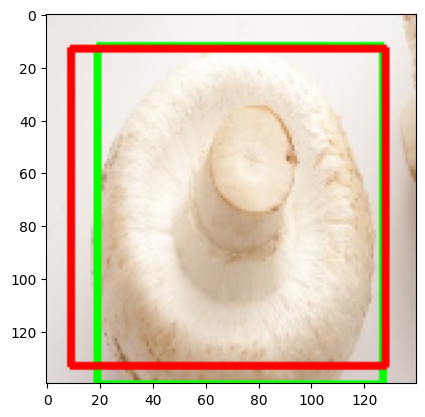

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox=valset[12]#ch,h,w
  image=image.unsqueeze(0).to(DEVICE)#batch,ch,h,w
  out_bbox=model(image)

  utils.compare_plots(image,gt_bbox,out_bbox)#green->ground truth bounding box(gt_bbox),red->out_bbox
